In [1]:
import os
import pandas as pd
import numpy as np
import time, gc
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pretrainedmodels
from argparse import Namespace
from sklearn.utils import shuffle
from apex import amp

In [2]:
'''
!pip install opencv-python
!pip install fastparquet
!pip install pyarrow
!pip install snappy
!conda install python-snappy -y
'''

'\n!pip install opencv-python\n!pip install fastparquet\n!pip install pyarrow\n!pip install snappy\n!conda install python-snappy -y\n'

In [3]:
!ls /mnt/chicm/data/bengali

bengaliai-cv19.zip	   test_image_data_3.parquet
class_map.csv		   train.csv
sample_submission.csv	   train_image_data_0.parquet
test.csv		   train_image_data_1.parquet
test_image_data_0.parquet  train_image_data_2.parquet
test_image_data_1.parquet  train_image_data_3.parquet
test_image_data_2.parquet


In [2]:
!ls /home/chec/data/bengali

class_map.csv		       test_image_data_3.parquet.zip
sample_submission.csv	       train.csv.zip
test.csv		       train_image_data_0.parquet.zip
test_image_data_0.parquet.zip  train_image_data_1.parquet.zip
test_image_data_1.parquet.zip  train_image_data_2.parquet.zip
test_image_data_2.parquet.zip  train_image_data_3.parquet.zip


In [2]:
DATA_DIR = '/home/chec/data/bengali'

In [3]:
train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
test_df = pd.read_csv(f'{DATA_DIR}/test.csv')
class_map_df = pd.read_csv(f'{DATA_DIR}/class_map.csv')
sample_sub_df = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')

In [ ]:
train_df.head()

In [9]:
train_df.shape

(200840, 5)

In [10]:
len(train_df.image_id.unique())

200840

In [11]:
train_df.grapheme_root.value_counts()

72     5736
64     5596
13     5420
107    5321
23     5149
       ... 
130     144
158     143
102     141
33      136
73      130
Name: grapheme_root, Length: 168, dtype: int64

In [22]:
df = pd.read_parquet(f'{DATA_DIR}/train_image_data_0.parquet')
df.head()

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


In [13]:
df.shape

(50210, 32333)

In [14]:
df2 = df.set_index('image_id')

In [15]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
image_id,,,,,,,,,,,,,,,,,,,,,
Train_0,254,253,252,253,251,252,253,251,251,253,...,253,253,253,253,253,253,253,253,253,251
Train_1,251,244,238,245,248,246,246,247,251,252,...,255,255,255,255,255,255,255,255,255,254
Train_2,251,250,249,250,249,245,247,252,252,252,...,254,253,252,252,253,253,253,253,251,249
Train_3,247,247,249,253,253,252,251,251,250,250,...,254,254,254,254,254,253,253,252,251,252
Train_4,249,248,246,246,248,244,242,242,229,225,...,255,255,255,255,255,255,255,255,255,255


In [50]:
df2.index

Index(['Train_0', 'Train_1', 'Train_2', 'Train_3', 'Train_4', 'Train_5',
       'Train_6', 'Train_7', 'Train_8', 'Train_9',
       ...
       'Train_50200', 'Train_50201', 'Train_50202', 'Train_50203',
       'Train_50204', 'Train_50205', 'Train_50206', 'Train_50207',
       'Train_50208', 'Train_50209'],
      dtype='object', name='image_id', length=50210)

In [4]:
HEIGHT = 137
WIDTH = 236

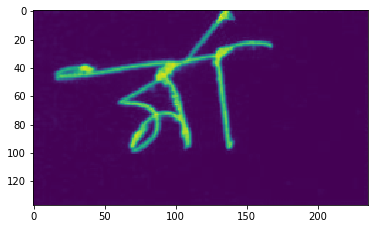

In [23]:
img = 255 - df.iloc[10, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
plt.imshow(img)

In [8]:
#img2 = cv2.resize(img, (256, 128))
#plt.imshow(img2)

In [4]:
import albumentations as albu

def get_train_augs(p=1.):
    return albu.Compose([
        #albu.HorizontalFlip(.5),
        albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5 ),
        albu.Blur(blur_limit=3, p=0.3),
        albu.OpticalDistortion(p=0.3),
        albu.GaussNoise(p=0.3)
        #albu.GridDistortion(p=.33),
        #albu.HueSaturationValue(p=.33) # not for grey scale
    ], p=p)

In [8]:
augs = get_train_augs(1.0)

In [9]:
img.shape

NameError: name 'img' is not defined

In [10]:
#x=augs(image=img)['image']

In [11]:
#plt.imshow(x)

In [5]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

HEIGHT = 137
WIDTH = 236

class BengaliDataset(Dataset):
    def __init__(self, df, img_df, train_mode=True, test_mode=False):
        self.df = df
        self.img_df = img_df
        self.train_mode = train_mode
        self.test_mode = test_mode

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = self.get_img(row.image_id)
        img = cv2.resize(img, (224,224))
        #print(img.shape)
        if self.train_mode:
            augs = get_train_augs()
            img = augs(image=img)['image']
        
        img = np.expand_dims(img, axis=-1)
        
        img = transforms.functional.to_tensor(img)
        #img = transforms.functional.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        if self.test_mode:
            return img
        else:
            return img, torch.tensor([row.grapheme_root, row.vowel_diacritic, row.consonant_diacritic])

    def get_img(self, img_id):
        return 255 - self.img_df.loc[img_id].values.reshape(HEIGHT, WIDTH).astype(np.uint8)

    def __len__(self):
        return len(self.df)
    
def get_train_val_loaders(batch_size=4, val_batch_size=4, dev_mode=False):
    train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
    train_df = shuffle(train_df, random_state=1234)
    print(train_df.shape)

    if dev_mode:
        img_df = pd.read_parquet(f'{DATA_DIR}/train_image_data_0.parquet').set_index('image_id')
        train_df = train_df.iloc[:1000]
    else:
        img_dfs = [pd.read_parquet(f'{DATA_DIR}/train_image_data_{i}.parquet') for i in range(4)]
        img_df = pd.concat(img_dfs, axis=0).set_index('image_id')
    print(img_df.shape)
    split_index = int(len(train_df) * 0.9)
    
    train = train_df.iloc[:split_index]
    val = train_df.iloc[split_index:]
    print(train.shape, val.shape)
    
    train_ds = BengaliDataset(train, img_df, True, False)
    val_ds = BengaliDataset(val, img_df, False, False)
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
    train_loader.num = len(train_ds)

    val_loader = DataLoader(val_ds, batch_size=val_batch_size, shuffle=False, num_workers=8, drop_last=False)
    val_loader.num = len(val_ds)

    return train_loader, val_loader

In [13]:
#train_loader, val_loader = get_train_val_loaders(dev_mode=True)

In [14]:
'''
for img, y in train_loader:
    print(img.size(), y.size())
    print(y)
    #print(img)
    #plt.imshow(img.squeeze()[0].numpy())
    break
'''

'\nfor img, y in train_loader:\n    print(img.size(), y.size())\n    print(y)\n    #print(img)\n    #plt.imshow(img.squeeze()[0].numpy())\n    break\n'

# model

In [8]:
#import pretrainedmodels

In [6]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [81]:
#model_name = 'resnet50' # could be fbresnet152 or inceptionresnetv2
#model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet').cuda()
#model.eval()

In [82]:
#model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained=False).cuda()


In [83]:
#model.features(torch.randn((2, 3, 137, 236)).cuda()).size()

torch.Size([2, 2048, 5, 8])

In [84]:
#model.last_linear.in_features

2048

In [7]:
class BengaliNet(nn.Module):
    def __init__(self, backbone_name):
        super(BengaliNet, self).__init__()
        self.n_grapheme = 168
        self.n_vowel = 11
        self.n_consonant = 7
        
        self.num_classes = self.n_grapheme + self.n_vowel + self.n_consonant
        
        self.conv0 = nn.Conv2d(1, 3, kernel_size=1, stride=1, padding=0)
        
        self.backbone = pretrainedmodels.__dict__[backbone_name](num_classes=1000, pretrained='imagenet')
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(self.backbone.last_linear.in_features, self.num_classes)

    def logits(self, x):
        x = self.avg_pool(x)
        x = F.dropout2d(x, 0.2, self.training)
        x = x.view(x.size(0), -1)
        return self.fc(x)
    
    def forward(self, x):
        x = self.conv0(x)
        #print(x.size())
        x = self.backbone.features(x)
        x = self.logits(x)

        return x

In [8]:
MODEL_DIR = './models'
def create_model(args):
    model = BengaliNet(backbone_name=args.backbone)
    model_file = os.path.join(MODEL_DIR, args.backbone, args.ckp_name)

    parent_dir = os.path.dirname(model_file)
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)

    print('model file: {}, exist: {}'.format(model_file, os.path.exists(model_file)))

    if args.predict and (not os.path.exists(model_file)):
        raise AttributeError('model file does not exist: {}'.format(model_file))

    if os.path.exists(model_file):
        print('loading {}...'.format(model_file))
        model.load_state_dict(torch.load(model_file))
    
    return model, model_file

In [11]:
'''
args = Namespace()
args.backbone = 'se_resnext50_32x4d'
args.ckp_name = 'best_model.pth'
args.predict = False

bnet = create_model(args)[0].cuda()
'''

"\nargs = Namespace()\nargs.backbone = 'se_resnext50_32x4d'\nargs.ckp_name = 'best_model.pth'\nargs.predict = False\n\nbnet = create_model(args)[0].cuda()\n"

In [103]:
#bnet = BengaliNet('se_resnext50_32x4d').cuda()

In [108]:
#bnet(torch.randn((2, 1, 137, 236)).cuda()).size()

torch.Size([2, 3, 137, 236])


torch.Size([2, 186])

# train

In [40]:
round(1/9, 6)

0.111111

In [9]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    #y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y_grapheme, average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y_vowel, average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y_consonant, average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score

def calc_metrics(preds0, preds1, preds2, y):
    assert len(y) == len(preds0) == len(preds1) == len(preds2)

    recall_grapheme = sklearn.metrics.recall_score(preds0, y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(preds1, y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(preds2, y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_recall_score = np.average(scores, weights=[2, 1, 1])
    
    metrics = {}
    metrics['recall'] = round(final_recall_score, 6)
    metrics['recall_grapheme'] = round(recall_grapheme, 6)
    metrics['recall_vowel'] = round(recall_vowel, 6)
    metrics['recall_consonant'] = round(recall_consonant, 6)
    
    metrics['acc_grapheme'] = round((preds0 == y[:, 0]).sum() / len(y), 6)
    metrics['acc_vowel'] = round((preds1 == y[:, 1]).sum() / len(y), 6)
    metrics['acc_consonant'] = round((preds2 == y[:, 2]).sum() / len(y), 6)
    
    
    return metrics

In [10]:
def accuracy(output, label, topk=(1,)):
    maxk = max(topk)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(label.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).sum().item()
        res.append(correct_k)
    return res

In [11]:
def criterion(outputs, y_true):
    # outputs: (N, 182)
    # y_true: (N, 3)
    
    outputs = torch.split(outputs, [168, 11, 7], dim=1)
    loss0 = F.cross_entropy(outputs[0], y_true[:, 0], reduction='mean')
    loss1 = F.cross_entropy(outputs[1], y_true[:, 1], reduction='mean')
    loss2 = F.cross_entropy(outputs[2], y_true[:, 2], reduction='mean')
    
    return loss0 + loss1 + loss2 #, loss0.item(), loss1.item(), loss2.item()

In [12]:
def validate(model, val_loader):
    model.eval()
    loss0, loss1, loss2 = 0., 0., 0.
    preds0, preds1,preds2 = [], [], []
    y_true = []
    with torch.no_grad():
        for x, y in val_loader:
            y_true.append(y)
            x, y = x.cuda(), y.cuda()
            outputs = model(x)
            outputs = torch.split(outputs, [168, 11, 7], dim=1)
            
            preds0.append(torch.max(outputs[0], dim=1)[1])
            preds1.append(torch.max(outputs[1], dim=1)[1])
            preds2.append(torch.max(outputs[2], dim=1)[1])
            loss0 += F.cross_entropy(outputs[0], y[:, 0], reduction='sum').item()
            loss1 += F.cross_entropy(outputs[1], y[:, 1], reduction='sum').item()
            loss2 += F.cross_entropy(outputs[2], y[:, 2], reduction='sum').item()
            
            # for debug
            #metrics = {}
            #metrics['loss_grapheme'] =  F.cross_entropy(outputs[0], y[:, 0], reduction='mean').item()
            #metrics['loss_vowel'] =  F.cross_entropy(outputs[1], y[:, 1], reduction='mean').item()
            #metrics['loss_consonant'] =  F.cross_entropy(outputs[2], y[:, 2], reduction='mean').item()
            #return metrics
    
    preds0 = torch.cat(preds0, 0).cpu().numpy()
    preds1 = torch.cat(preds1, 0).cpu().numpy()
    preds2 = torch.cat(preds2, 0).cpu().numpy()
    y_true = torch.cat(y_true, 0).numpy()
    
    #print('y_true:', y_true.shape)
    #print('preds0:', preds0.shape)
    
    metrics = calc_metrics(preds0, preds1, preds2, y_true)
    metrics['loss_grapheme'] = round(loss0 / val_loader.num, 6)
    metrics['loss_vowel'] = round(loss1 / val_loader.num, 6)
    metrics['loss_consonant'] = round(loss2 / val_loader.num, 6)
    
    return metrics
            

In [21]:
#train_loader, val_loader = get_train_val_loaders(batch_size=32, val_batch_size=128, dev_mode=True)

(200840, 5)
(200840, 32332)
(180756, 5) (20084, 5)


model file: ./models/se_resnext50_32x4d/best_model.pth, exist: False


In [13]:
def get_lrs(optimizer):
    lrs = []
    for pgs in optimizer.state_dict()['param_groups']:
        lrs.append(pgs['lr'])
    lrs = ['{:.6f}'.format(x) for x in lrs]
    return lrs

In [14]:
def save_model(model, model_file):
    parent_dir = os.path.dirname(model_file)
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
    if isinstance(model, nn.DataParallel):
        torch.save(model.module.state_dict(), model_file)
    else:
        torch.save(model.state_dict(), model_file)

In [15]:
def mixup(data, targets, alpha=1):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = (targets, shuffled_targets, lam)

    return data, targets


def mixup_criterion(outputs, targets):
    targets1, targets2, lam = targets
    #criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(outputs, targets1) + (1 - lam) * criterion(outputs, targets2)

In [16]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [17]:
np.random.random()

0.499245729413614

In [18]:
def train(args):
    global model

    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=0.0001)
    else:
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=0.0001)

    if args.lrs == 'plateau':
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=args.factor, patience=args.patience, min_lr=args.min_lr)
    else:
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, args.t_max, eta_min=args.min_lr)
        
    model, optimizer = amp.initialize(model, optimizer, opt_level="O1",verbosity=0)
    
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    best_metrics = 0.
    best_key = 'recall'
    
    val_metrics = validate(model, val_loader)
    print(val_metrics)
    best_metrics = val_metrics[best_key]
    
    model.train()
    #optimizer.zero_grad()

    #if args.lrs == 'plateau':
    #    lr_scheduler.step(best_metrics)
    #else:
    #    lr_scheduler.step()
    train_iter = 0

    for epoch in range(args.num_epochs):
        train_loss = 0

        current_lr = get_lrs(optimizer)
        bg = time.time()
        for batch_idx, (img, targets) in enumerate(train_loader):
            train_iter += 1
            img, targets  = img.cuda(), targets.cuda()
            #do_mixup = False #(np.random.random() < 0.4)
            
            #if do_mixup:
            #    img, targets = mixup(img, targets)
            batch_size = img.size(0)
          
            
            
            #if do_mixup:
            #    loss = mixup_criterion(outputs, targets)
            #else:
            #    loss = criterion(outputs, targets)
            r = np.random.rand()
            #if args.beta > 0 and r < args.cutmix_prob:
            if r < 0.5:
                # generate mixed sample
                lam = np.random.beta(args.beta, args.beta)
                rand_index = torch.randperm(img.size()[0]).cuda()
                target_a = targets
                target_b = targets[rand_index]
                bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(), lam)
                img[:, :, bbx1:bbx2, bby1:bby2] = img[rand_index, :, bbx1:bbx2, bby1:bby2]
                # adjust lambda to exactly match pixel ratio
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))
                # compute output
                outputs = model(img)
                loss = criterion(outputs, target_a) * lam + criterion(outputs, target_b) * (1. - lam)
            else:
                img, targets = mixup(img, targets)
                outputs = model(img)
                loss = mixup_criterion(outputs, targets)
            
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            
            #loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            
            #if batch_idx % 4 == 0:
            #    optimizer.step()
            #    optimizer.zero_grad()

            train_loss += loss.item()
            print('\r {:4d} | {:.6f} | {:06d}/{} | {:.4f} | {:.4f} |'.format(
                epoch, float(current_lr[0]), batch_size*(batch_idx+1), train_loader.num, 
                loss.item(), train_loss/(batch_idx+1)), end='')

            if train_iter > 0 and train_iter % args.iter_val == 0:
                #outputs = torch.split(outputs, [168, 11, 7], dim=1)
            
                #preds0 = (torch.max(outputs[0], dim=1)[1]).cpu().numpy()
                #preds1 = (torch.max(outputs[1], dim=1)[1]).cpu().numpy()
                #preds2 = (torch.max(outputs[2], dim=1)[1]).cpu().numpy()
                #train_metrics = calc_metrics(preds0, preds1, preds2, targets.cpu().numpy())
                #print('train:', train_metrics)
                #save_model(model, model_file+'_latest')
                val_metrics = validate(model, val_loader)
                print('\nval:', val_metrics)
                
                if val_metrics[best_key] > best_metrics:
                    best_metrics = val_metrics[best_key]
                    save_model(model, model_file)
                    print('** saved')
                
                model.train()
                
                if args.lrs == 'plateau':
                    lr_scheduler.step(best_metrics)
                else:
                    lr_scheduler.step()
                current_lr = get_lrs(optimizer)
        
    

In [19]:
args = Namespace()
args.backbone = 'se_resnext50_32x4d'
args.ckp_name = 'best_model_224.pth'
args.predict = False
args.optim = 'Adam'
args.lr = 2e-5
args.lrs = 'cosine'
args.t_max = 12
args.factor = 0.6
args.patience = 3
args.min_lr = 1e-6
args.iter_val = 200
args.num_epochs = 100000
args.batch_size = 768
args.val_batch_size = 1024

args.beta = 1.0
args.cutmix_prob = 0.5

In [20]:
train_loader, val_loader = get_train_val_loaders(batch_size=args.batch_size, val_batch_size=args.val_batch_size)

(200840, 5)
(200840, 32332)
(180756, 5) (20084, 5)


In [21]:
model, model_file = create_model(args)
#if torch.cuda.device_count() > 1:
#    model = nn.DataParallel(model)
model = model.cuda()


model file: ./models/se_resnext50_32x4d/best_model_224.pth, exist: True
loading ./models/se_resnext50_32x4d/best_model_224.pth...


In [22]:
train(args) # 224, cutmix , mixup

{'recall': 0.985434, 'recall_grapheme': 0.978409, 'recall_vowel': 0.99054, 'recall_consonant': 0.994378, 'acc_grapheme': 0.977046, 'acc_vowel': 0.99293, 'acc_consonant': 0.993677, 'loss_grapheme': 0.151049, 'loss_vowel': 0.075938, 'loss_consonant': 0.058766}
    0 | 0.000020 | 096000/180756 | 3.1850 | 2.0828 |

KeyboardInterrupt: 

In [70]:
#save_model(model, model_file)

In [24]:
del model

In [73]:
!ls ./models/se_resnext50_32x4d

best_model.pth
